In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn

In [ ]:
#PREPARING DATA FOR REGRESSION
#We have some fake (fake) random data representing the properties of the binary
#We relate the quantities in a complicated way that represents the unknown error introduced by GSTLAL
#We want to recover the initial quantities, as the ML algorithm should be able to guess this complicated relation function

np.random.seed(21) #fix random seed so we can reproduce results

#Prepare example dataset:
Nsample=10000 #number of data points
dsample=5 #dimension of the data point DONT CHANGE
    #Example: we have Nsample injections, each of them with dsample parameters estimated
#We will simulate two random masses between 1.1 and 2.1, their two random magnitudes of the spin between 0 and 1, and a random angle between them, from 0 to pi
y=np.zeros((Nsample,dsample))
for i in range (0,Nsample):
    y[i][0:2]=1.1+ np.random.random_sample((1,2)) 
    y[i][2:4]=np.random.random_sample((1,2)) 
    y[i][4]=np.pi*np.random.random_sample((1,1)) 

In [ ]:
#this emulates the nonlinear effects introduced by the GSTLAL pipeline
def complicated_f(vector):
    x=vector[0]; y=vector[1]; z=vector[2]; w=vector[3]; v=vector[4]
    return [x*z+w**2-v/np.sqrt(y),y**3*(x+np.pi*w)/(1+v+3*z),np.sqrt((x-v)**2+(y-w)**2+(z-x)**2),np.sqrt(x)/(2*y**2*z+1)+v/(4*y*z*np.sqrt(v)+2)-w,np.sin(x+y)+z*w/(z+w+v)]

In [ ]:
#We prepare the results "from the pipeline"
errorpct=0.05  #noise percentage to introduce
x=np.zeros((Nsample,dsample));
for i in range (0,Nsample):
    x[i]=complicated_f(y[i])
    for j in range(0, dsample): #plus some random error up to specified % of the value
        x[i][j]=x[i][j]+x[i][j]*(-1)**np.random.randint(1,3)*errorpct*np.random.rand()

In [ ]:
##################################

In [2]:
#PREPARING DATA FOR REGRESSION
#We have some fake (fake) random data representing the properties of the binary
#We relate the quantities in a complicated way that represents the unknown error introduced by GSTLAL
#We want to recover the initial quantities, as the ML algorithm should be able to guess this complicated relation function

np.random.seed(21) #fix random seed so we can reproduce results

#Prepare example dataset:
Nsample=10000 #number of data points
dsample=7 #dimension of the data point DONT CHANGE
    #Example: we have Nsample injections, each of them with dsample parameters estimated
#We will simulate two random masses between 1.1 and 2.1, their two random magnitudes of the spin between 0 and 1, and a random angle between them, from 0 to pi
y=np.zeros((Nsample,dsample))
for i in range (0,Nsample):
    y[i][0:2]=1.1+ np.random.random_sample((1,2)) 
    maxm=np.maximum(y[i][0],y[i][1])
    minm=np.minimum(y[i][0],y[i][1])
    y[i][0]=maxm
    y[i][1]=minm
    y[i][2:4]=np.random.random_sample((1,2)) 
    y[i][4]=np.pi*np.random.random_sample((1,1)) 
    y[i][5]=y[i][0]/y[i][1]  #added mass ratio!
    y[i][6]=(y[i][0]*y[i][1])**(3.0/5)/(y[i][0]+y[i][1])**(1.0/5)    #added chirp mass!

In [3]:
#this emulates the nonlinear effects introduced by the GSTLAL pipeline
def complicated_f(vector):
    x=vector[0]; y=vector[1]; z=vector[2]; w=vector[3]; v=vector[4]
    a=vector[5]; b=vector[6]
    return [x*z+w**2-v/np.sqrt(y)+(1-a)/(b+3), 
            y**3*(a+np.pi*w)/(1+v+3*z), 
            np.sqrt((x-v)**2+(b-w)**2+(z-x)**2), 
            np.sqrt(x+a)/(2*y**2*z+1)+v/(4*y*z*np.sqrt(np.abs(v-b))+2)-w,
            np.sin(x+y)+(a-z)*w/(z+w+v),
            (a**2+(b-y)+x/3)*(z*np.sqrt(w)-v),b]

In [4]:
#We prepare the results "from the pipeline"
errorpct=0.05  #noise percentage to introduce
x=np.zeros((Nsample,dsample));
for i in range (0,Nsample):
    x[i]=complicated_f(y[i])
    for j in range(0, dsample): #plus some random error up to specified % of the value
        x[i][j]=x[i][j]+x[i][j]*(-1)**np.random.randint(1,3)*errorpct*np.random.rand()

In [ ]:
##################################

In [ ]:
#Then train the ML with data x and tag y, to see if it can discover the complicated function relating the quantities


In [5]:
#Separate into training and tesing sets
training_data = y[:7000,:]
testing_data = y[7000:,:]

training_noisyd = x[:7000,:]
testing_noisyd = x[7000:,:]


In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RationalQuadratic, RBF, ConstantKernel as C

In [7]:
%%time
# Method 1
DP = DotProduct()
gpr = GaussianProcessRegressor(kernel=DP, alpha=1e-7, optimizer='fmin_l_bfgs_b',n_restarts_optimizer=0)
gpr.fit(training_noisyd, training_data)
predicted_data, std = gpr.predict(testing_noisyd, return_std=True)
gpr.score(testing_noisyd, testing_data)

CPU times: user 2min 5s, sys: 7.15 s, total: 2min 12s
Wall time: 22.7 s


0.8519994737039089

In [14]:
%%time
# Method 2
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-7, n_restarts_optimizer=0)
gpr.fit(training_noisyd, training_data)
predicted_data, std = gpr.predict(testing_noisyd, return_std=True)
gpr.score(testing_noisyd, testing_data)

CPU times: user 1h 6min 8s, sys: 2min 15s, total: 1h 8min 23s
Wall time: 13min 48s


0.794330997024266

In [16]:
%%time
# Method 3
kernel = RationalQuadratic(length_scale=1.0, alpha=2, length_scale_bounds=(.1, 10), alpha_bounds=(1e-4, 4))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-7, optimizer='fmin_l_bfgs_b',n_restarts_optimizer=0)
gpr.fit(training_noisyd, training_data)
predicted_data, std = gpr.predict(testing_noisyd, return_std=True)
gpr.score(testing_noisyd, testing_data)

CPU times: user 23min 4s, sys: 56.8 s, total: 24min 1s
Wall time: 6min 19s


0.9831006429095244

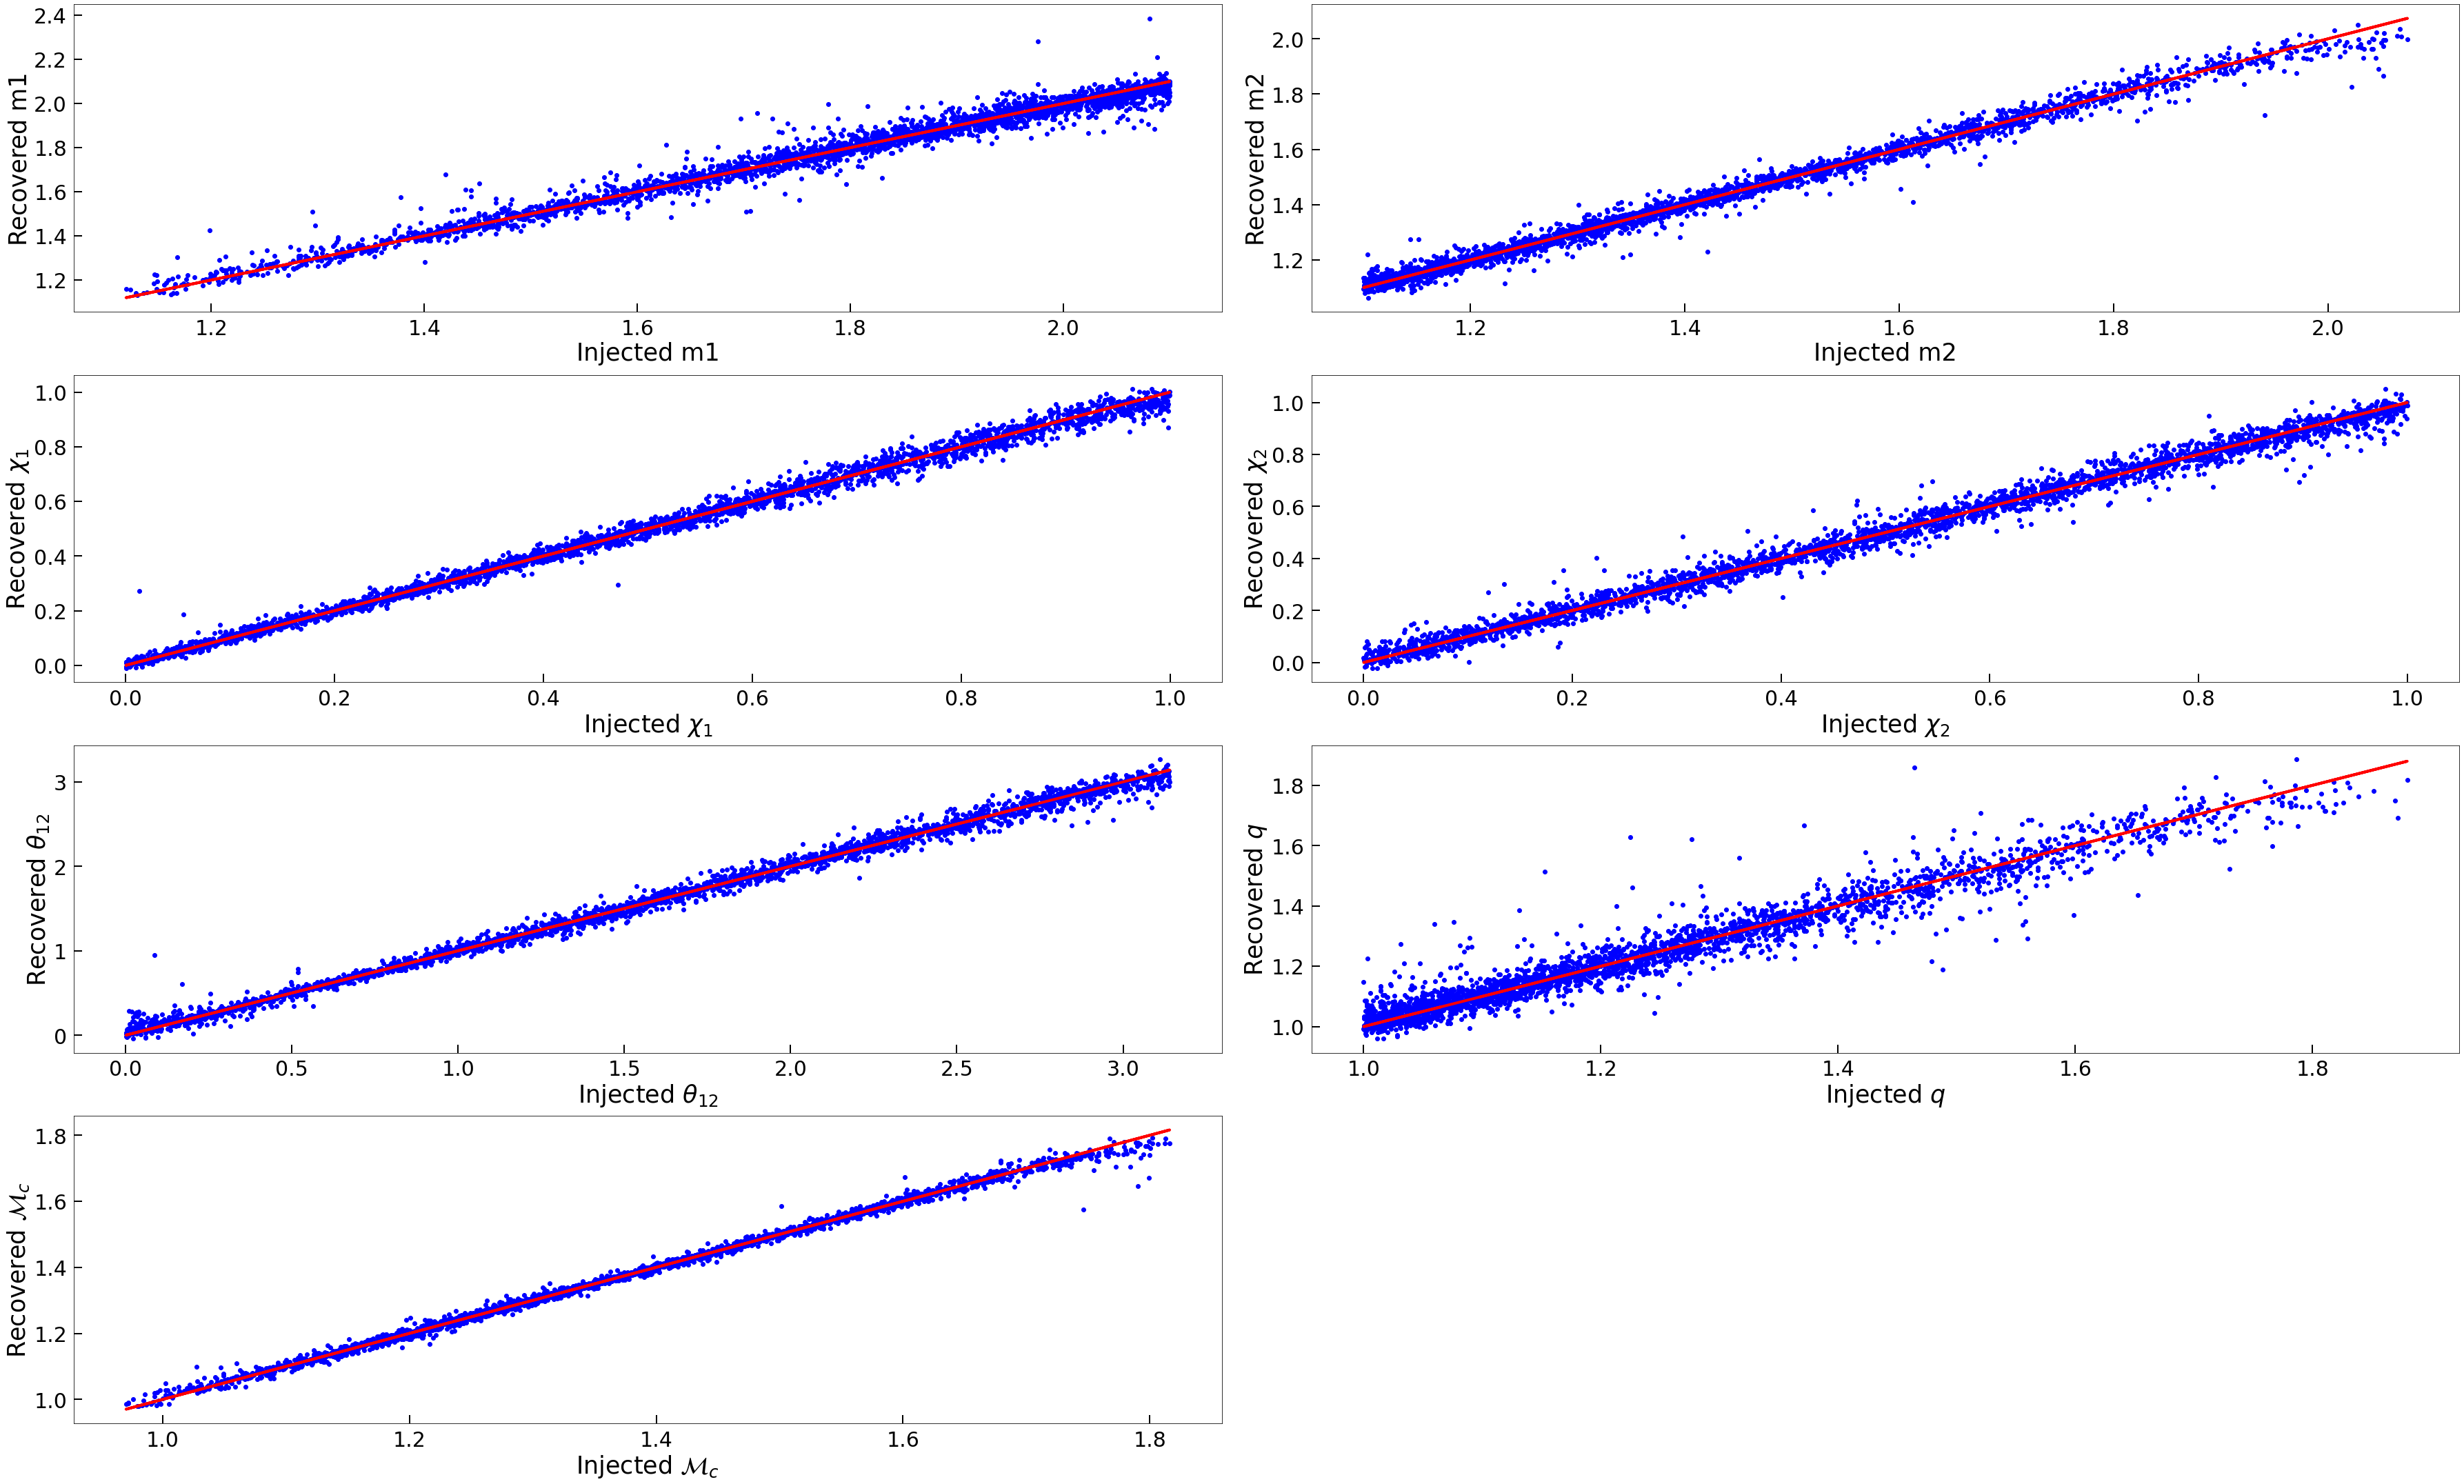

In [17]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(50, 30), sharex=False)
#plt.title('mass 1 recovery')
for i in [0,1,2,3]:
    for j in [0,1]:
        axs[i,j].tick_params(axis='x', direction='in',length=12, width=2, pad=10, labelsize=30)
        axs[i,j].tick_params(axis='y', which='both', direction='in',length=12, width=2, pad=10, labelsize=30)


axs[0,0].set_xlabel('Injected m1', fontsize=35)
axs[0,0].set_ylabel('Recovered m1', fontsize=35)
axs[0,1].set_xlabel('Injected m2', fontsize=35)
axs[0,1].set_ylabel('Recovered m2', fontsize=35)
axs[1,0].set_xlabel(r'Injected $\chi_1$', fontsize=35)
axs[1,0].set_ylabel(r'Recovered $\chi_1$', fontsize=35)
axs[1,1].set_xlabel(r'Injected $\chi_2$', fontsize=35)
axs[1,1].set_ylabel(r'Recovered $\chi_2$', fontsize=35)
axs[2,0].set_xlabel(r'Injected $\theta_{12}$', fontsize=35)
axs[2,0].set_ylabel(r'Recovered $\theta_{12}$', fontsize=35)
axs[2,1].set_xlabel(r'Injected $q$', fontsize=35)
axs[2,1].set_ylabel(r'Recovered $q$', fontsize=35)
axs[3,0].set_xlabel(r'Injected $\mathcal{M}_c$', fontsize=35)
axs[3,0].set_ylabel(r'Recovered $\mathcal{M}_c$', fontsize=35)

it = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0]]
for q, it in enumerate(it):
    for i in np.arange(0,len(predicted_data)):
        axs[it[0],it[1]].plot(testing_data[i][q], predicted_data[i][q], 'ob', label="Prediction")
    axs[it[0],it[1]].plot(testing_data[:,q], testing_data[:,q], 'r-', lw=4.0, label="True value")
axs[3,1].remove()
fig.tight_layout()
plt.show()
outfile = 'figures/GPR_RBFCK_nro0.pdf'
fig.savefig(outfile)



## Using only $m_1$ and $\mathcal{M}_c$

In [33]:
print(y[0])

[1.38910966 1.14872488 0.72096635 0.02161625 0.64692545 1.20926227
 1.09869937]


In [30]:
#NEW!: dataset only with only mass1 and the chirp mass
y_nomass2=np.delete(y,1,1)
x_nomass2=np.delete(x,1,1)

In [34]:
training_data = y_nomass2[:7000,:]
testing_data = y_nomass2[7000:,:]

training_noisyd = x_nomass2[:7000,:]
testing_noisyd = x_nomass2[7000:,:]

In [35]:
%%time
# Method 1
DP = DotProduct()
gpr = GaussianProcessRegressor(kernel=DP, alpha=1e-7, optimizer='fmin_l_bfgs_b',n_restarts_optimizer=0)
gpr.fit(training_noisyd, training_data)
predicted_data, std = gpr.predict(testing_noisyd, return_std=True)
gpr.score(testing_noisyd, testing_data)

CPU times: user 2min 3s, sys: 7.67 s, total: 2min 11s
Wall time: 21.9 s


0.8036324225136076

In [41]:
%%time
# Method 2
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-7, n_restarts_optimizer=0)
gpr.fit(training_noisyd, training_data)
predicted_data, std = gpr.predict(testing_noisyd, return_std=True)
gpr.score(testing_noisyd, testing_data)

CPU times: user 39min 4s, sys: 1min 38s, total: 40min 43s
Wall time: 8min 36s


0.49555916091598484

In [39]:
%%time
# Method 3
kernel = RationalQuadratic(length_scale=1.0, alpha=2, length_scale_bounds=(.1, 10), alpha_bounds=(1e-4, 4))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-7, optimizer='fmin_l_bfgs_b',n_restarts_optimizer=0)
gpr.fit(training_noisyd, training_data)
predicted_data, std = gpr.predict(testing_noisyd, return_std=True)
gpr.score(testing_noisyd, testing_data)

CPU times: user 22min 34s, sys: 59.8 s, total: 23min 34s
Wall time: 6min 10s


0.9158691740137138

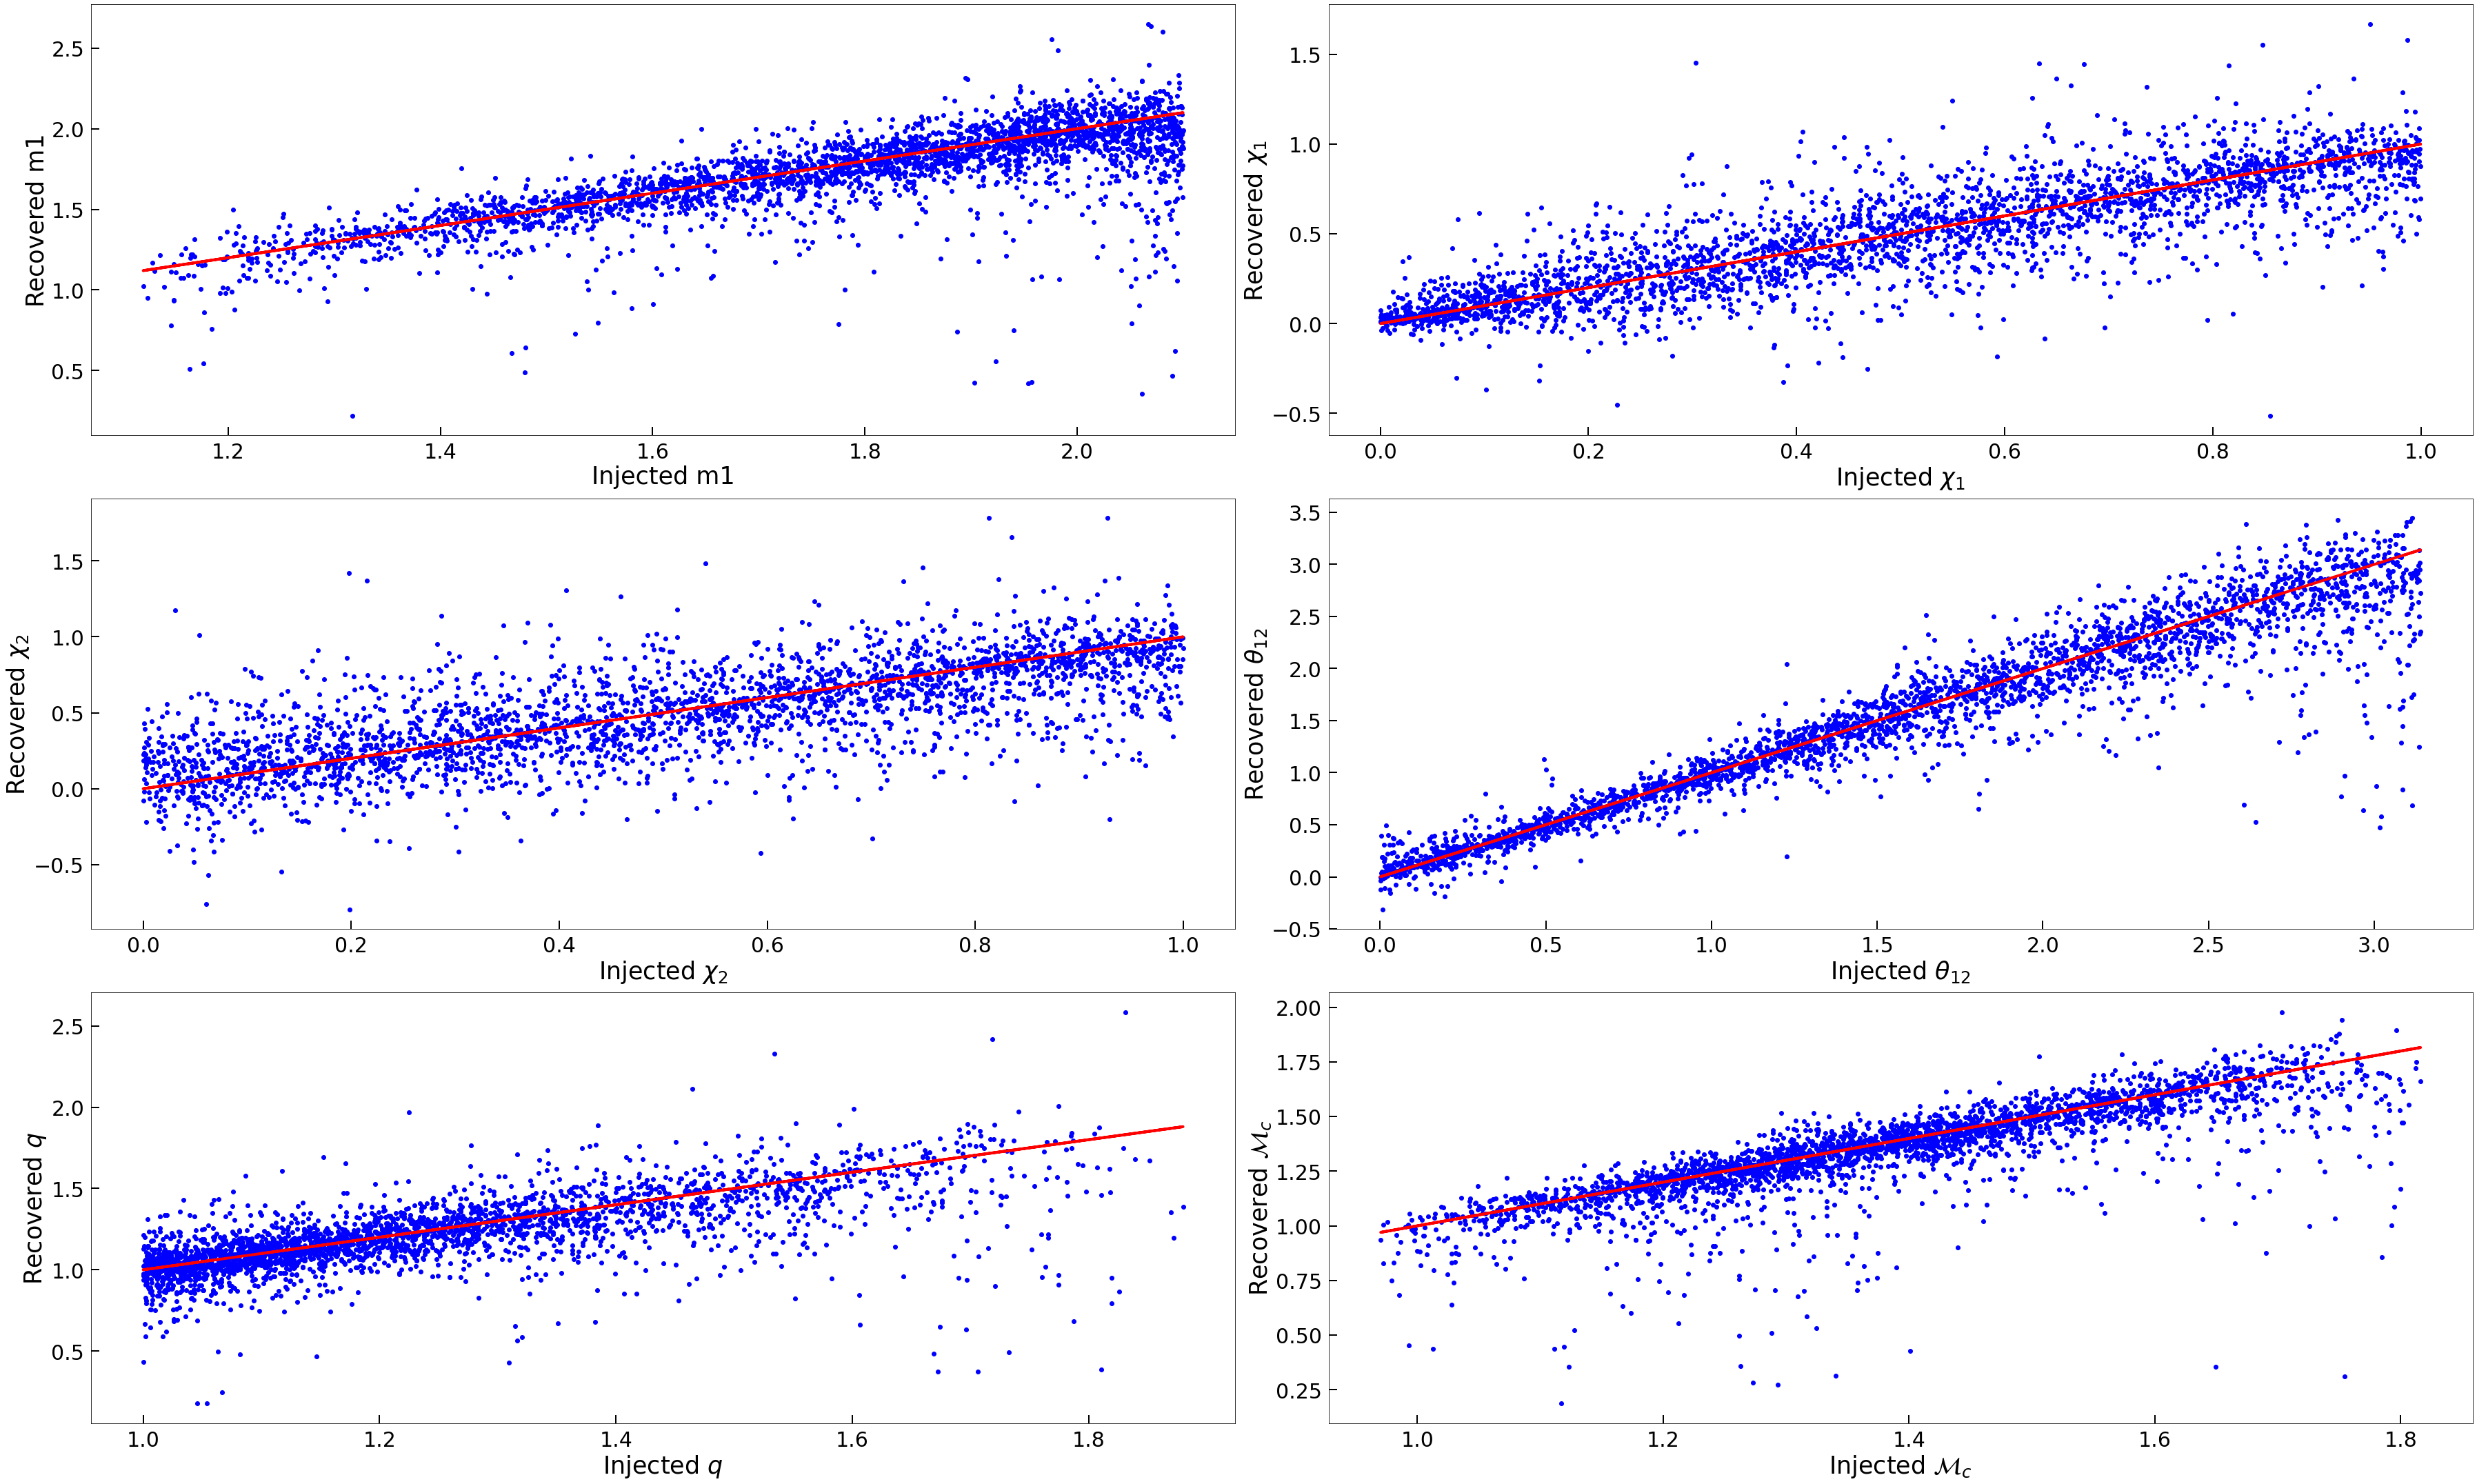

In [42]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(50, 30), sharex=False)
#plt.title('mass 1 recovery')
for i in [0,1,2]:
    for j in [0,1]:
        axs[i,j].tick_params(axis='x', direction='in',length=12, width=2, pad=10, labelsize=30)
        axs[i,j].tick_params(axis='y', which='both', direction='in',length=12, width=2, pad=10, labelsize=30)


axs[0,0].set_xlabel('Injected m1', fontsize=35)
axs[0,0].set_ylabel('Recovered m1', fontsize=35)
axs[0,1].set_xlabel(r'Injected $\chi_1$', fontsize=35)
axs[0,1].set_ylabel(r'Recovered $\chi_1$', fontsize=35)
axs[1,0].set_xlabel(r'Injected $\chi_2$', fontsize=35)
axs[1,0].set_ylabel(r'Recovered $\chi_2$', fontsize=35)
axs[1,1].set_xlabel(r'Injected $\theta_{12}$', fontsize=35)
axs[1,1].set_ylabel(r'Recovered $\theta_{12}$', fontsize=35)
axs[2,0].set_xlabel(r'Injected $q$', fontsize=35)
axs[2,0].set_ylabel(r'Recovered $q$', fontsize=35)
axs[2,1].set_xlabel(r'Injected $\mathcal{M}_c$', fontsize=35)
axs[2,1].set_ylabel(r'Recovered $\mathcal{M}_c$', fontsize=35)

it = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1]]
for q, it in enumerate(it):
    for i in np.arange(0,len(predicted_data)):
        axs[it[0],it[1]].plot(testing_data[i][q], predicted_data[i][q], 'ob', label="Prediction")
    axs[it[0],it[1]].plot(testing_data[:,q], testing_data[:,q], 'r-', lw=4.0, label="True value")

fig.tight_layout()
plt.show()
outfile = 'figures/GPR_RBFCK_nro0.pdf'
fig.savefig(outfile)



In [ ]:
plt.figure(figsize=(10,10))
plt.title('mass 1 recovery')
plt.xlabel('Injected m1')
plt.ylabel('Recovered m1')
#plt.plot(training_data, testing_data, "r:", label=r"$f(x) = x\,\sin(x)$")
for i in np.arange(0,len(predicted_data)):
    plt.plot(testing_data[i][0], predicted_data[i][0], 'ob', label="Prediction")
plt.plot(testing_data[:,0], testing_data[:,0], 'r-', label="True value")

plt.fill(
    #np.concatenate([testing_noisyd, testing_noisyd[::-1]]),
    np.concatenate([predicted_data - 1.9600 * std, (predicted_data + 1.9600 * std)[::-1]]),
    alpha=0.5,
    fc="b",
    ec="None",
    label="95% confidence interval",
)
plt.show()

In [23]:
y[:,:6]

array([[1.38910966, 1.14872488, 0.72096635, 0.02161625, 0.64692545,
        1.20926227],
       [1.40227189, 1.15077326, 0.66391029, 0.30811439, 1.83340607,
        1.21854752],
       [1.96740448, 1.16957095, 0.13324052, 0.17812466, 1.55800863,
        1.68215915],
       ...,
       [1.72803764, 1.58199403, 0.0926533 , 0.48865868, 0.39130432,
        1.09231615],
       [2.04268224, 1.34456762, 0.52915673, 0.30054197, 1.46517688,
        1.51921123],
       [1.5902513 , 1.49356984, 0.93352704, 0.37274807, 3.08970144,
        1.06473179]])

In [ ]:
y_nomass2=y[:,:6]
x_nomass2=x[:,:6]